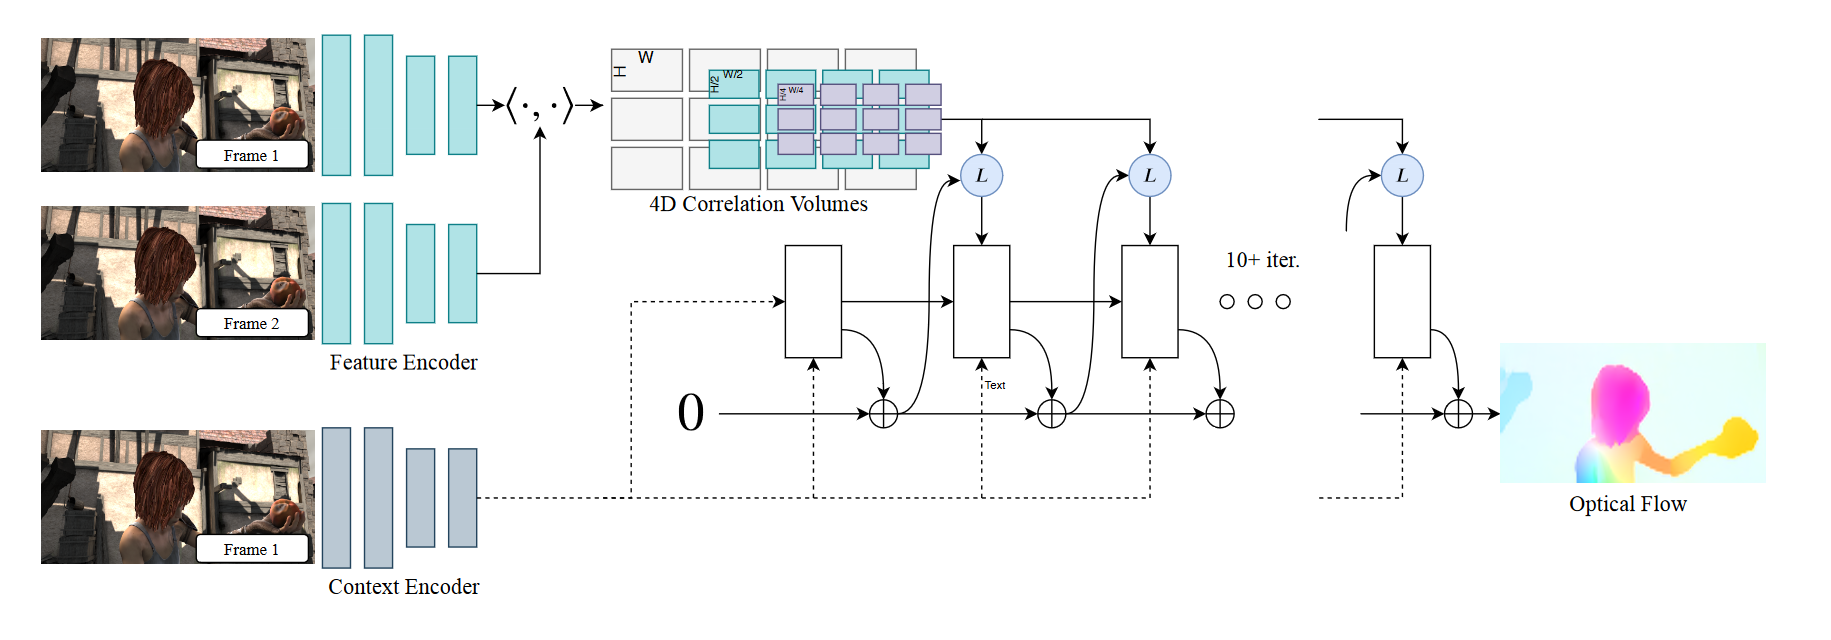


# Optical Flow:  RAFT 
RAFT es una arquitectura de red neuronal profunda para la estimación de flujo óptico. RAFT extrae características por píxel, construye volúmenes de correlación 4D a múltiples escalas para todas las parejas de píxeles y actualiza iterativamente un campo de flujo a través de una unidad recurrente que realiza búsquedas en los volúmenes de correlación.

https://arxiv.org/pdf/2003.12039.pdf

Necesario instalar PyAV:
pip install av

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from pathlib import Path
from urllib.request import urlretrieve
import cv2


plt.rcParams["savefig.bbox"] = "tight"



def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Hace una matriz
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

Elegimos dos partes del vídeo para ver las diferencias.
Para ello elegimos el frame 100 y 101 y el frame 150 y 151

In [ ]:
from torchvision.io import read_video
frames, _, _ = read_video("people2.mp4")
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

El modelo RAFT trabaja directamente con las imagenes RGB tipo flotante con valores de [-1 a 1], pero el video que tenemos descargado son imagenes con valores entre 0 y 255 tipo entero. Además nos interesa reducir el tamaño para ir más rápido.

In [ ]:

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # pasa [0, 1] a [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

#verificamos el tipo de imagen de entrada
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

#usamos cuda para ir más rapido
device = "cuda" if torch.cuda.is_available() else "cpu"

#preposesamos la imágen
img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

#verificamos que el tipo de imagen que obtenemos cumple con el tipo que necesita de entrada el modelo
print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

## Estimando el Flujo óptico usando RAFT 
se usa la implentación `~torchvision.models.optical_flow.raft_large`, que se basa en el algoritmo publicado en 2020 en ` <https://arxiv.org/abs/2003.12039>`_.



In [ ]:
from torchvision.models.optical_flow import raft_large #se puede cambiar "raft_large" por "raft_small" para ir más rápido, pero peor resultado

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

In [5]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -5.954047203063965, max = 7.024177074432373


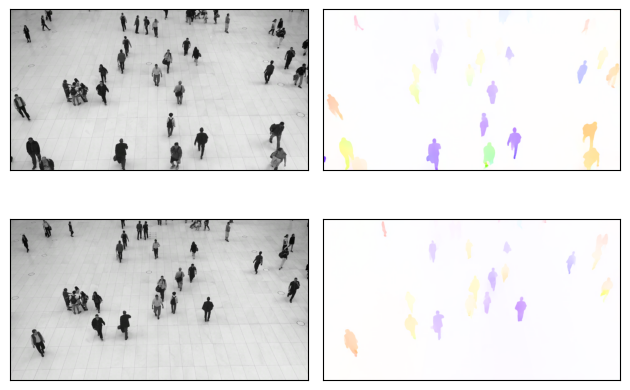

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)


img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)
